# Наивный байесовский классификатор

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification, make_moons
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

## Генерация данных

Все рассматриваемые данные будут сгенерированными. Для рассмотрения мы сгенерируем 3 набора данных

In [25]:
np.random.seed(42)

Функция для данных сложной структуры из презентации

In [37]:
def generate_complex_data(n_samples=100):
    
    # Класс A: Кластер в форме кольца
    theta_A = 2 * np.pi * np.random.rand(n_samples)
    r_A = 3 + 0.5 * np.random.randn(n_samples)
    x_A = r_A * np.cos(theta_A)
    y_A = r_A * np.sin(theta_A)
    data_A = np.column_stack((x_A, y_A))
    labels_A = np.zeros(n_samples)

    # Класс B: Кластер в центре
    data_B = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], n_samples)
    labels_B = np.ones(n_samples)

    # Класс C: Два вытянутых кластера
    data_C1 = np.random.multivariate_normal([5, 5], [[1, 0.5], [0.5, 1]], int(n_samples/2))
    data_C2 = np.random.multivariate_normal([-5, -5], [[1, -0.5], [-0.5, 1]], int(n_samples/2))
    data_C = np.vstack((data_C1, data_C2))
    labels_C = np.full(n_samples, 2)

    X = np.vstack((data_A, data_B, data_C))
    y = np.hstack((labels_A, labels_B, labels_C))

    return X, y

Генерация данных:
- линейно разделимые данные простой структуры
- датасет с полумесяцами, плохо линейно разделимый
- линейно неразделимые данные сложной формы

In [38]:
# Датасет 1: простые блобы
X_blobs, y_blobs = make_blobs(n_samples=200, centers=3, cluster_std=1.8, random_state=42)

# Датасет 2: более сложный, линейно неразделимый
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)

# Датасет 3: сложные линейно неразделимые данные
X_complex, y_complex = generate_complex_data(n_samples=200)

Визуализируем данные

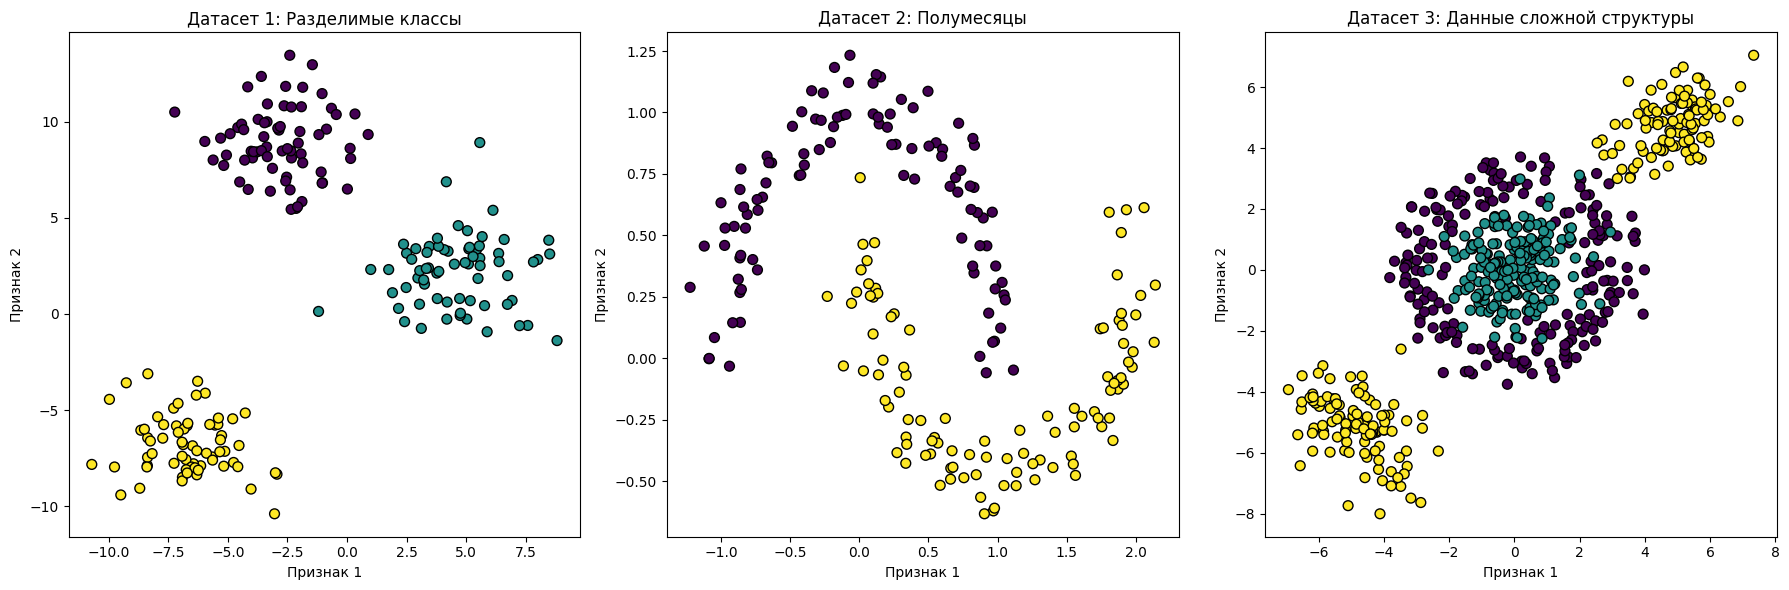

In [39]:
# Визуализируем наборы данных
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Датасет 1: блобы
axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', s=50, edgecolor='k')
axes[0].set_title('Датасет 1: Разделимые классы')
axes[0].set_xlabel('Признак 1')
axes[0].set_ylabel('Признак 2')

# Датасет 2: полумесяцы
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', s=50, edgecolor='k')
axes[1].set_title('Датасет 2: Полумесяцы')
axes[1].set_xlabel('Признак 1')
axes[1].set_ylabel('Признак 2')

# Датасет 3: сложный
axes[2].scatter(X_complex[:, 0], X_complex[:, 1], c=y_complex, cmap='viridis', s=50, edgecolor='k')
axes[2].set_title('Датасет 3: Данные сложной структуры')
axes[2].set_xlabel('Признак 1')
axes[2].set_ylabel('Признак 2')

plt.tight_layout()
plt.show()


Разделим данные на обучающуюся и тестовую выборку

In [40]:
# Разделим данные на обучающую и тестовую выборки
X_train_blobs, X_test_blobs, y_train_blobs, y_test_blobs = train_test_split(X_blobs, y_blobs, test_size=0.3, random_state=42)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, test_size=0.3, random_state=42)
X_train_complex, X_test_complex, y_train_complex, y_test_complex = train_test_split(X_complex, y_complex, test_size=0.3, random_state=42)

## Построение модели наивного байесовского классификатора

Основные формулы модели:
- формула для оценки меток классов (основная формула модели) $$\hat C_k = \underset{C_k}{\arg\max}\ \underbrace{\left(\log P(y = C_k)+  \sum_{i=1}^m\log P(x_i|y = C_k)\right)}_{\approx\log P(x_1,\ldots,x_m|y=C_k)}.;$$
- формула для априорных вероятностей $$P(y = C_k) = \dfrac{\text{количество объектов класса } k}{\text{количество всех объектов}};$$
- формула для гауссовского распределения признаков $$P(x_i|y = C_k) = \dfrac{1}{\sigma_{C_k}\sqrt{2\pi}}\exp \left(-\dfrac{(x_i - \mu_{C_k})^2}{2 \sigma_{C_k}^2}\right),$$
где по методу максимального правдоподобия
$$\mu_{C_k} = \dfrac 1 m\sum_{i=1}^m x_i,\ \sigma_{C_k}^2 = \dfrac 1 m\sum_{i=1}^m (x_i - \mu_{C_k})^2.$$

Ниже приведена реализация модели

In [43]:
class NaiveBayesClassifier():

    # Плотность нормального распределения для признаков
    def norm_pdf(self, x, mean, var):
        return np.exp(-0.5 * np.power((x - mean) / np.sqrt(var), 2)) / (np.sqrt(2 * np.pi) * np.sqrt(var))


    def map_estimation(self, x):
        log_posteriors = []

        # Вычисление апостериорных вероятностей
        for i, c in enumerate(self.classes):           
            log_posteriors.append(np.log(self.priors[i]) + np.sum(np.log(self.norm_pdf(x, self.mean[i], self.var[i])))) 

        # Вычисление оценки класса как argmax
        return self.classes[np.argmax(log_posteriors)]


    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes) # Количество классов C_1, ..., C_k

        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros((n_classes))

        for i, C in enumerate(self.classes):
            X_C = X[y == C] # Выбираем из выборки все объекты, для которых класс равен C
            self.mean[i] = X_C.mean(axis=0) # Заметьте, что среднее и std берутся по признакам, а не по объектам
            self.var[i] = X_C.var(axis=0)
            self.priors[i] = len(X_C) / n_samples # Априорные вероятности


    def predict(self, X):
        return np.array([self.map_estimation(x) for x in X]) # Прогнозируем метку класса как апостериорный максимум

Определим функцию для визуализации границ решений модели

In [1]:
# Функция для отображения границ решения
def plot_decision_boundaries(X, y, model, ax=None, title="Decision Boundaries"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Определяем границы графика с небольшим запасом
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Создаем сетку точек для построения границы
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Предсказываем класс для каждой точки сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Определяем цветовую схему
    colors = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])

    # Отображаем границы решения
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=colors)

    # Отображаем обучающие точки
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor='k', cmap=colors)

    # Добавляем легенду
    legend1 = ax.legend(*scatter.legend_elements(), title="Классы")
    ax.add_artist(legend1)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)
    ax.set_xlabel('Признак 1')
    ax.set_ylabel('Признак 2')

    return ax

В итоге строим модели для наших данных

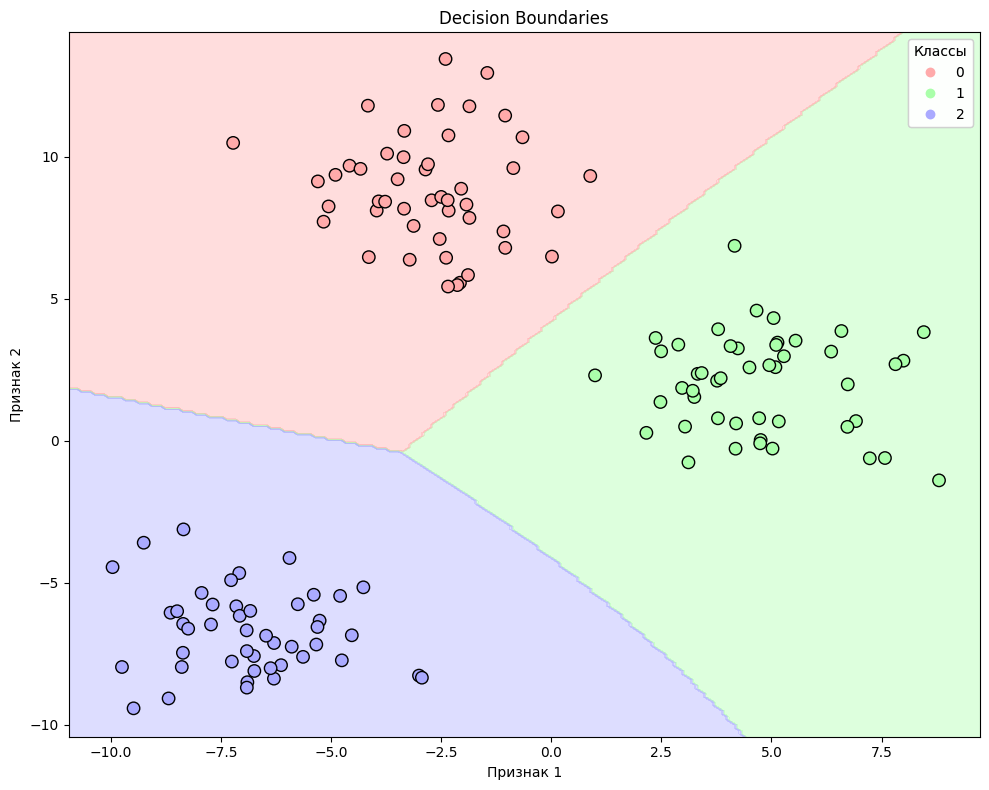

In [41]:
nb = NaiveBayesClassifier()
nb.fit(X_train_blobs, y_train_blobs)

plot_decision_boundaries(X_train_blobs, y_train_blobs, nb)

plt.tight_layout()
plt.show()

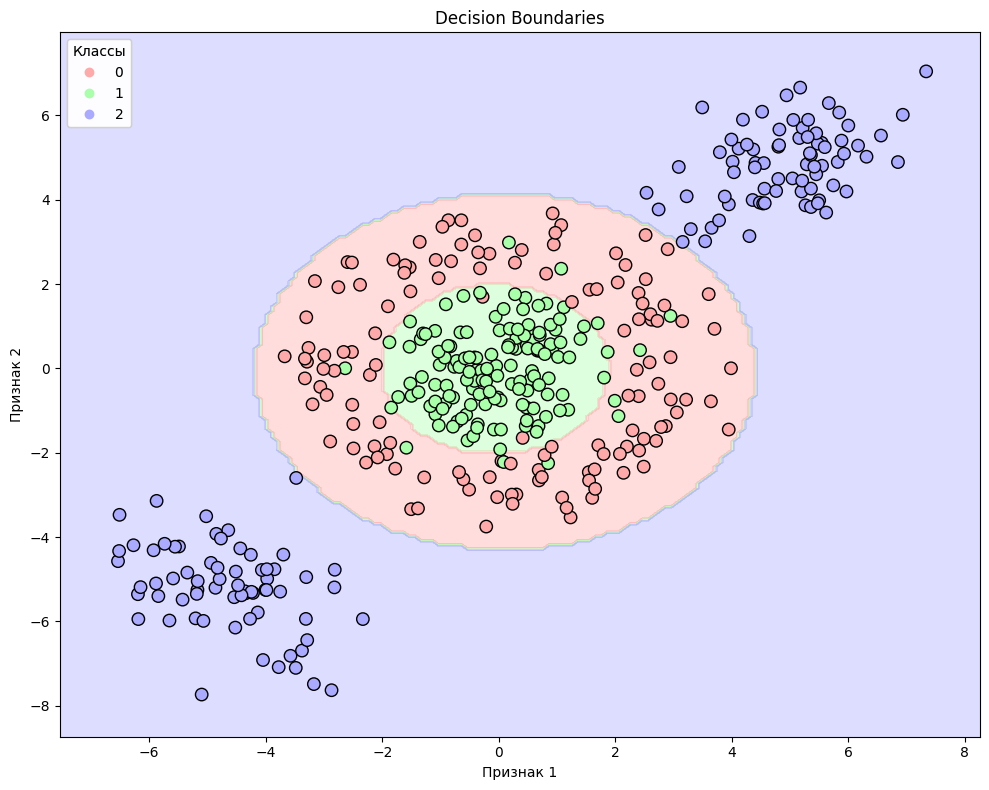

In [42]:
nb = NaiveBayesClassifier()
nb.fit(X_train_complex, y_train_complex)

plot_decision_boundaries(X_train_complex, y_train_complex, nb)

plt.tight_layout()
plt.show()

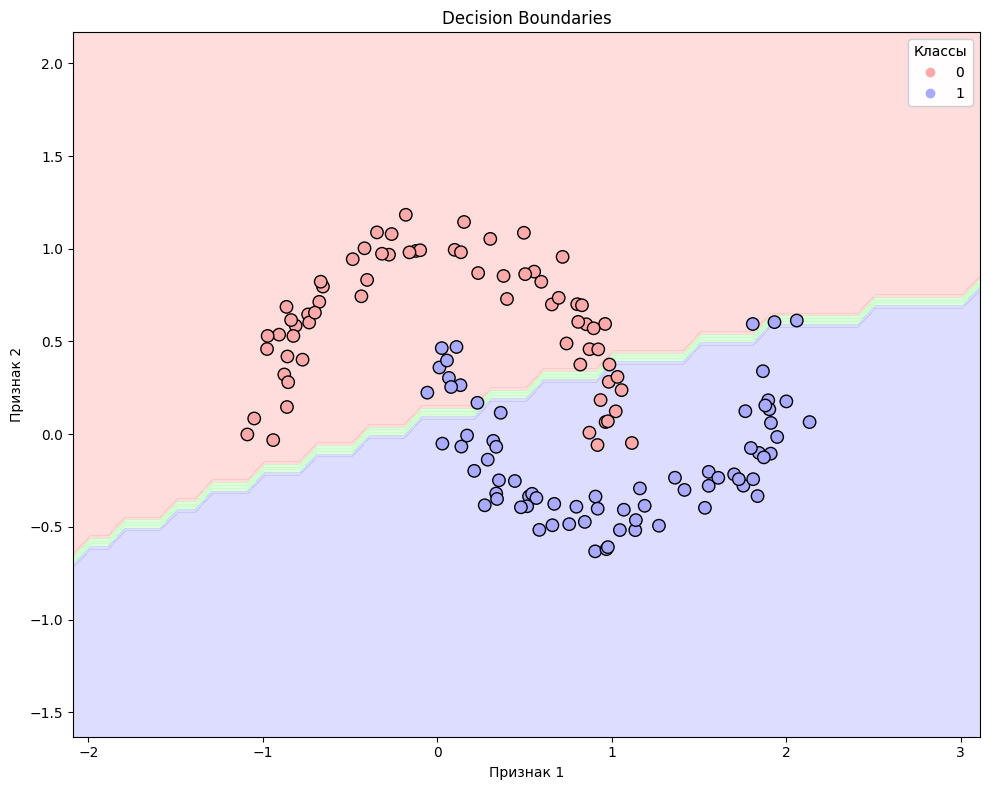

In [44]:
nb = NaiveBayesClassifier()
nb.fit(X_train_moons, y_train_moons)

plot_decision_boundaries(X_train_moons, y_train_moons, nb)

plt.tight_layout()
plt.show()